# Example reduction

In [15]:
import sys
import os
sys.path.append(os.path.expanduser('~/git/LiquidsReflectometer/reduction'))

import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

#%matplotlib notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

In [16]:
import mantid
import mantid.simpleapi as api
mantid.kernel.config.setLogLevel(3)

ConfigService-[Error] logging set to PRIO_ERROR priority


In [17]:
print(mantid.__version__)
print(sys.version)

6.3.0
3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]


In [18]:
import importlib
from lr_reduction import workflow
from lr_reduction import template
from lr_reduction import output
from lr_reduction import event_reduction
from lr_reduction import reduction_template_reader

In [21]:
importlib.reload(workflow)
importlib.reload(output)
importlib.reload(event_reduction)

data_dir = os.path.expanduser('~/git/LiquidsReflectometer/reduction/data')
template_path = os.path.join(data_dir, 'template.xml')

for i in range(198409, 198417):
    ws = api.Load("REF_L_%s" % i)
    workflow.reduce(ws, template_path, output_dir=data_dir, pre_cut=1, post_cut=1, average_overlap=False)


wl=15; ths=0.610382; offset=0.01
Template: TOF = [51977.0051592. 65268.5238077],  Q = [0.005, -0.02]
Background on both sides: [133 135] [148 150]
wl=12.386; ths=0.610058; offset=0.01
Template: TOF = [41761.0114019. 55052.5300504],  Q = [0.005, -0.02]
Background on both sides: [133 135] [148 150]
wl=9.74; ths=0.610058; offset=0.01
Template: TOF = [31419.955747. 44711.4743955],  Q = [0.005, -0.02]
Background on both sides: [133 135] [148 150]
wl=7.043; ths=0.609896; offset=0.01
Template: TOF = [20879.5826929. 34171.1013413],  Q = [0.005, -0.02]
Background on both sides: [133 135] [148 150]
wl=4.25; ths=0.609733; offset=0.01
Template: TOF = [9964.0239461. 23255.5425945],  Q = [0.005, -0.02]
Background on both sides: [133 135] [148 150]
wl=4.25; ths=1.19271; offset=0.01
Template: TOF = [9964.0239461. 23255.5425945],  Q = [0.005, -0.02]
Background on both sides: [133 135] [148 150]
wl=4.25; ths=2.35284; offset=0.01
Template: TOF = [9964.0239461. 23255.5425945],  Q = [0.005, -0.02]
Backgrou

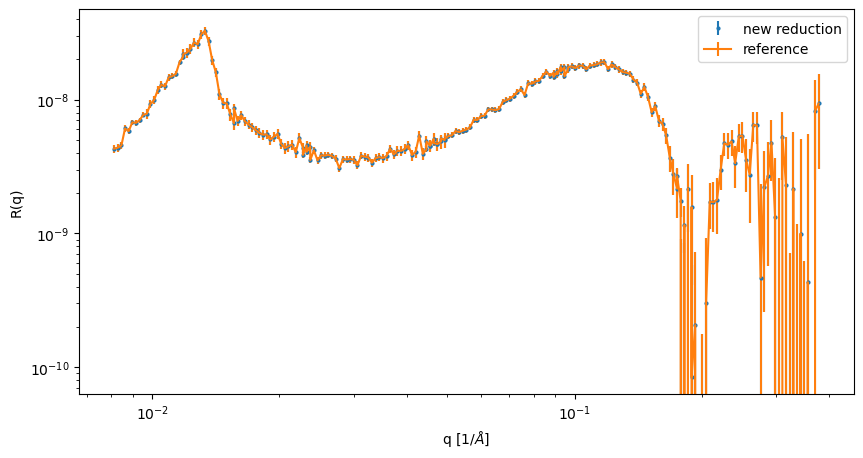

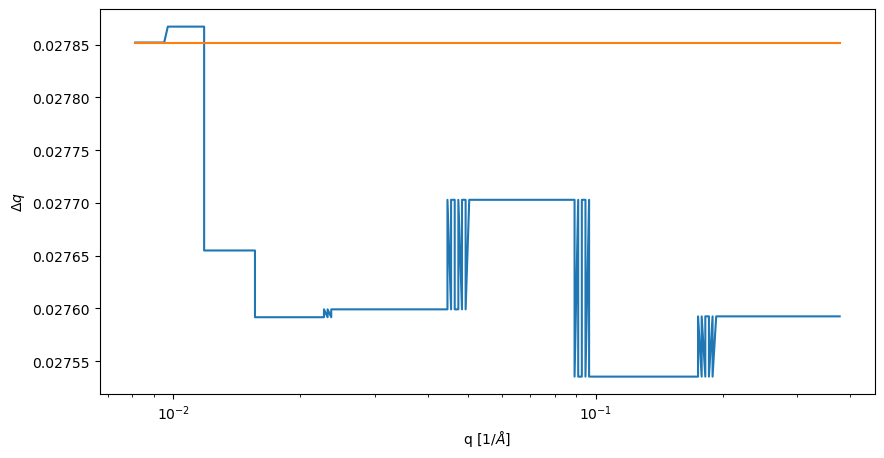

-4.0766001685454967e-16
-1.0677559690233781e-15
4.851021216396422e-17
0.0052853337944813086


In [26]:
reduced_path = os.path.join(data_dir, 'reference_rq.txt')
if os.path.isfile(reduced_path):
    _data = np.loadtxt(reduced_path).T

reduced_path = os.path.join(data_dir, 'REFL_198409_combined_data_auto.txt')
if os.path.isfile(reduced_path):
    _refl = np.loadtxt(reduced_path).T

fig, ax = plt.subplots(figsize=(10,5))
plt.errorbar(_refl[0], _refl[1]*_refl[0]**4, yerr=_refl[2]*_refl[0]**4, markersize=4, marker='.', linestyle='', label='new reduction')
plt.errorbar(_data[0], _data[1]*_data[0]**4, yerr=_data[2]*_data[0]**4, markersize=4, marker='', linestyle='-', label='reference')

plt.legend()
plt.xlabel('q [$1/\AA$]')
plt.ylabel('R(q)')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

if len(_data[1])==len(_refl[1]):
    # dQ is computed for each run in the new implementation
    fig, ax = plt.subplots(figsize=(10,5))
    plt.plot(_refl[0], _refl[3]/_refl[0], label="new_reduction")
    plt.plot(_data[0], _data[3]/_data[0], label="reference")

    plt.xlabel('q [$1/\AA$]')
    plt.ylabel('$\Delta q$')
    ax.set_yscale('linear')
    ax.set_xscale('log')
    plt.show()
else:
    print("len(ref) = %s; len(new) = %s" % (len(_data[1]), len(_refl[1])))

for i in range(4):
    print(np.sum(_data[i]-_refl[i]))


In [8]:
importlib.reload(workflow)
importlib.reload(output)
importlib.reload(event_reduction)
importlib.reload(reduction_template_reader)

data_dir = os.path.expanduser('~/git/LiquidsReflectometer/reduction/data')
template_path = os.path.join(data_dir, 'template.xml')



def write_template(template_file, output_dir):
    #self.data_peak_range = [140, 150]
    #self.background_roi = [137, 153,100, 200]

    with open(template_file, "r") as fd:
        xml_str = fd.read()
        data_sets = reduction_template_reader.from_xml(xml_str)

        # Left background
        for i in range(8):          
            print("Peak: %s" % data_sets[i].data_peak_range)
            data_sets[i].background_roi[0] = data_sets[i].data_peak_range[0]-5
            data_sets[i].background_roi[1] = data_sets[i].data_peak_range[0]

        xml_str = reduction_template_reader.to_xml(data_sets)
        with open(os.path.join(output_dir, 'template_left.xml'), 'w') as fd:
            fd.write(xml_str)

        # Right background
        for i in range(8):          
            data_sets[i].background_roi[0] = data_sets[i].data_peak_range[1]
            data_sets[i].background_roi[1] = data_sets[i].data_peak_range[1]+5

        xml_str = reduction_template_reader.to_xml(data_sets)
        with open(os.path.join(output_dir, 'template_right.xml'), 'w') as fd:
            fd.write(xml_str)

        # Invalid background
        for i in range(8):          
            data_sets[i].background_roi[0] = data_sets[i].data_peak_range[0]+1
            data_sets[i].background_roi[1] = data_sets[i].data_peak_range[1]-1

        xml_str = reduction_template_reader.to_xml(data_sets)
        with open(os.path.join(output_dir, 'template_invalid.xml'), 'w') as fd:
            fd.write(xml_str)


write_template(template_path, data_dir)
template_path_left = os.path.join(data_dir, 'template_left.xml')
template_path_right = os.path.join(data_dir, 'template_right.xml')
template_path_invalid = os.path.join(data_dir, 'template_invalid.xml')

for i in range(198409, 198417):
    ws = api.Load("REF_L_%s" % i)
    workflow.reduce(ws, template_path_invalid, output_dir=data_dir, pre_cut=1, post_cut=1, average_overlap=False)



Peak: [136, 147]
Peak: [136, 147]
Peak: [136, 147]
Peak: [136, 147]
Peak: [136, 147]
Peak: [136, 147]
Peak: [134, 148]
Peak: [134, 148]
wl=15; ths=0.610382; offset=0.01
Template: TOF = [51977.0051592. 65268.5238077],  Q = [0.005, -0.02]
Invalid background: [137 146]
wl=12.386; ths=0.610058; offset=0.01
Template: TOF = [41761.0114019. 55052.5300504],  Q = [0.005, -0.02]
Invalid background: [137 146]
wl=9.74; ths=0.610058; offset=0.01
Template: TOF = [31419.955747. 44711.4743955],  Q = [0.005, -0.02]
Invalid background: [137 146]
wl=7.043; ths=0.609896; offset=0.01
Template: TOF = [20879.5826929. 34171.1013413],  Q = [0.005, -0.02]
Invalid background: [137 146]
wl=4.25; ths=0.609733; offset=0.01
Template: TOF = [9964.0239461. 23255.5425945],  Q = [0.005, -0.02]
Invalid background: [137 146]
wl=4.25; ths=1.19271; offset=0.01
Template: TOF = [9964.0239461. 23255.5425945],  Q = [0.005, -0.02]
Invalid background: [137 146]
wl=4.25; ths=2.35284; offset=0.01
Template: TOF = [9964.0239461. 2325